# Autoencoder Implementation on MNIST

Implementation of a standard Autoencoder for image reconstruction and dimensionality reduction.



## 1. Setup & Imports <a id='setup'></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import os

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Loading <a id='data'></a>

We'll use the MNIST dataset with standard normalization.

In [2]:
batch_size = 128
learning_rate = 0.001
num_epochs = 20
latent_dim = 32

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]

Training samples: 60000
Test samples: 10000


### Visualize Sample Data

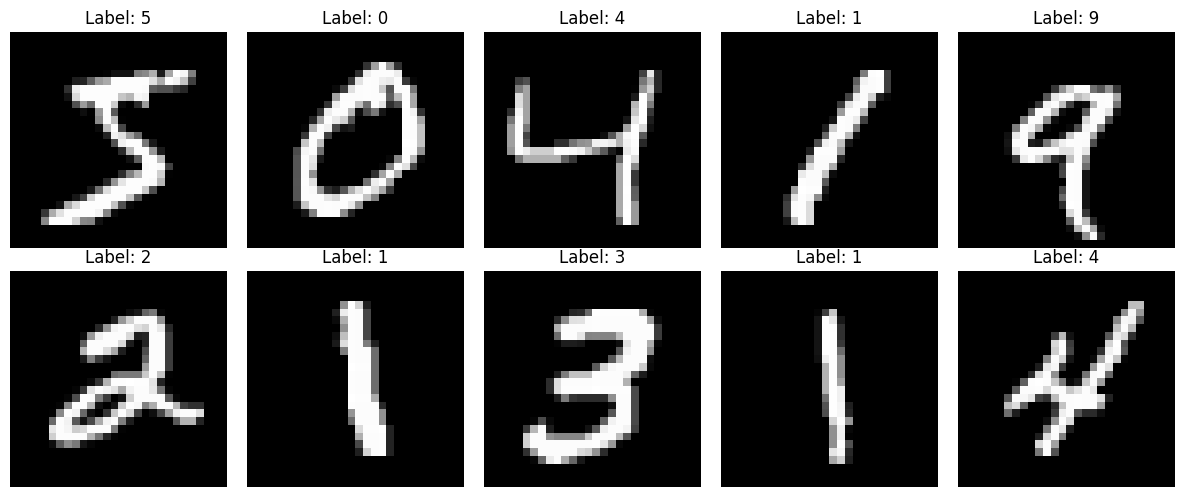

In [3]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Model Architecture <a id='model'></a>

The Autoencoder consists of:
- **Encoder**: Compresses 784-dim input to latent dimension
- **Decoder**: Reconstructs from latent space back to 784-dim output

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=32):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        return self.encoder(x)

# Initialize model
model = Autoencoder(latent_dim=latent_dim).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal parameters: {total_params:,}')

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

Total parameters: 1,141,296


## 4. Training <a id='training'></a>

We'll use Mean Squared Error (MSE) loss for reconstruction.

In [5]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training history
train_losses = []
test_losses = []

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, _ in tqdm(loader, desc='Training', leave=False):
        images = images.view(-1, 784).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, _ in loader:
            images = images.view(-1, 784).to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            running_loss += loss.item()

    return running_loss / len(loader)

In [7]:
# Training loop
print('Starting training...\n')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

print('\nTraining completed!')

Starting training...



Epoch [1/20] - Train Loss: 0.0530, Test Loss: 0.0312


Epoch [2/20] - Train Loss: 0.0268, Test Loss: 0.0233


Epoch [3/20] - Train Loss: 0.0216, Test Loss: 0.0195


Epoch [4/20] - Train Loss: 0.0183, Test Loss: 0.0170


Epoch [5/20] - Train Loss: 0.0164, Test Loss: 0.0152


Epoch [6/20] - Train Loss: 0.0146, Test Loss: 0.0135


Epoch [7/20] - Train Loss: 0.0132, Test Loss: 0.0127


Epoch [8/20] - Train Loss: 0.0122, Test Loss: 0.0118


Epoch [9/20] - Train Loss: 0.0113, Test Loss: 0.0115


Epoch [10/20] - Train Loss: 0.0107, Test Loss: 0.0104


Epoch [11/20] - Train Loss: 0.0101, Test Loss: 0.0101


Epoch [12/20] - Train Loss: 0.0096, Test Loss: 0.0095


Epoch [13/20] - Train Loss: 0.0091, Test Loss: 0.0092


Epoch [14/20] - Train Loss: 0.0087, Test Loss: 0.0088


Epoch [15/20] - Train Loss: 0.0084, Test Loss: 0.0086


Epoch [16/20] - Train Loss: 0.0082, Test Loss: 0.0084


Epoch [17/20] - Train Loss: 0.0079, Test Loss: 0.0082


Epoch [18/20] - Train Loss: 0.0077, Test Loss: 0.0080


Epoch [19/20] - Train Loss: 0.0075, Test Loss: 0.0078


Epoch [20/20] - Train Loss: 0.0073, Test Loss: 0.0076

Training completed!


### Plot Training Curves

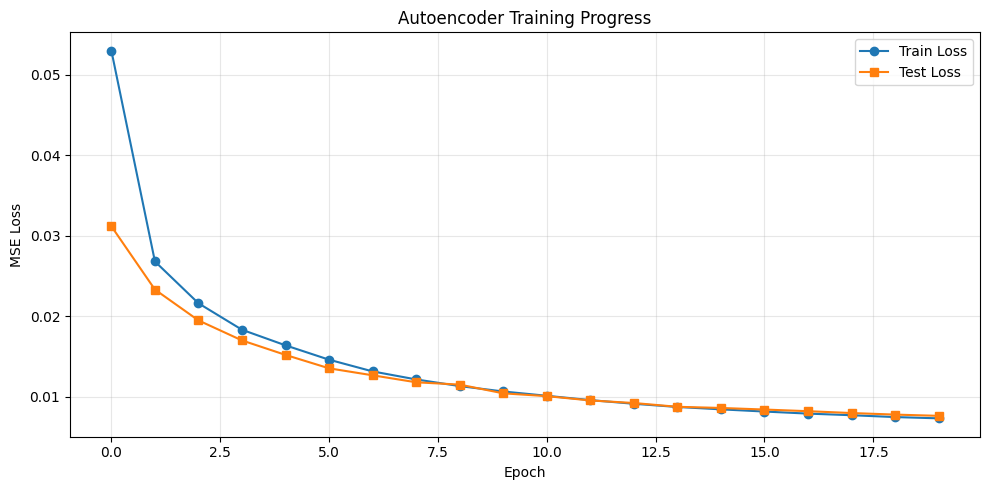

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Evaluation & Visualization <a id='evaluation'></a>

Compare original images with their reconstructions.

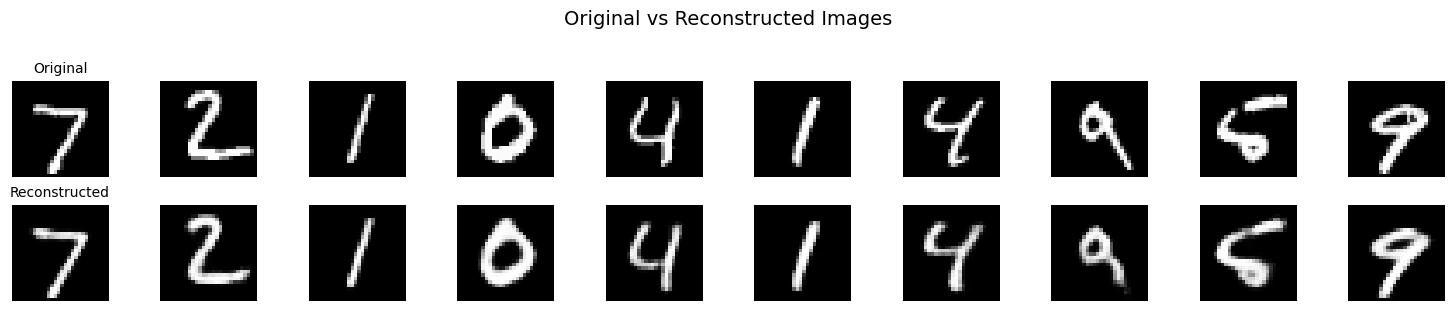

In [9]:
# Get sample images
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    images_flat = images.view(-1, 784)
    reconstructed = model(images_flat)
    reconstructed = reconstructed.view(-1, 1, 28, 28)

# Visualize
n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)

    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10)

plt.suptitle('Original vs Reconstructed Images', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Latent Space Exploration <a id='latent'></a>

Visualize the learned latent representations using t-SNE.

In [10]:
# Extract latent representations
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Encoding'):
        images = images.view(-1, 784).to(device)
        latent = model.encode(images)
        latent_vectors.append(latent.cpu().numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

print(f'Latent space shape: {latent_vectors.shape}')

Encoding: 100%|██████████| 79/79 [00:00<00:00, 80.40it/s]

Latent space shape: (10000, 32)


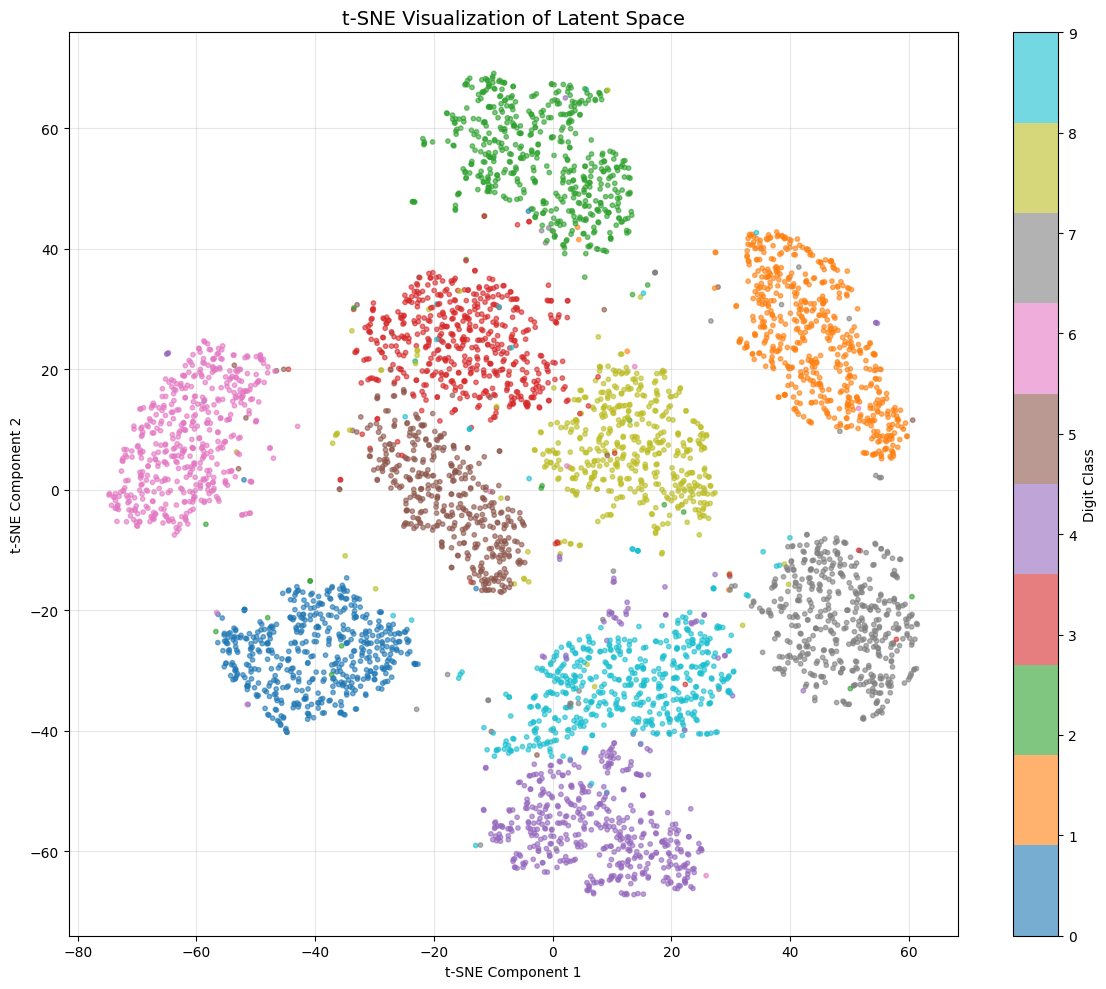

In [11]:
# Apply t-SNE for visualization (using subset for speed)
n_samples = 5000
indices = np.random.choice(len(latent_vectors), n_samples, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_vectors[indices])

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=labels_array[indices], cmap='tab10',
                     alpha=0.6, s=10)
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save Model

In [12]:
# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Save model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'latent_dim': latent_dim,
    'num_epochs': num_epochs
}

torch.save(checkpoint, 'checkpoints/autoencoder.pth')
print('Model saved successfully!')

Model saved successfully!
